In [1]:
%matplotlib inline


# Generating 3D Volume Projections

This script illustrates using ASPIRE's Simulation source to
generate projections of a Volume using prescribed rotations.


In [9]:
import logging
import os

import numpy as np

from aspire.noise import WhiteNoiseAdder
from aspire.source.simulation import Simulation
from aspire.utils import Rotation
from aspire.basis import FSPCABasis
from aspire.volume import Volume

logger = logging.getLogger(__name__)

## Configure how many images we'd like to project



In [3]:
n_img = 10

## Load our Volume data
This example starts with an mrc, which can be loaded as an ASPIRE Volume.



In [4]:
DATA_DIR = "map-data"  # Tutorial example data folder
v = Volume.load(
    os.path.join(DATA_DIR, "emd_14930.map.gz"), dtype=np.float64
)

# Then we downsample to 60x60x60
v.downsample(60)

2023-03-06 17:05:56,317 INFO [aspire.volume.volume] map-data/emd_14930.map.gz with dtype float32 loaded as <class 'numpy.float64'>


1 float64 volumes arranged as a (1,) stack each of size 60x60x60.

## Defining rotations
We generate a collection of in-plane rotations about the z-axis.



In [5]:
# First get a list of angles to test
thetas = np.linspace(0, 2 * np.pi, num=n_img, endpoint=False)

# Instantiate ASPIRE's Rotation class with the set of angles.
# This will allow us to use or access the rotations in a variety of ways.
rots = Rotation.about_axis("z", thetas, dtype=np.float64)

## Configure Noise
We can define controlled noise and have the Simulation apply it to our projection images.



In [6]:
noise_variance = 1e-3  # Normally this would be derived from a desired SNR.

# Then create a CustomNoiseAdder based on that variance, which is passed to Simulation.
white_noise_adder = WhiteNoiseAdder(var=noise_variance)

## Setup Simulation Source



In [13]:
# Simulation will randomly shift and amplify images by default.
# Instead we define the following parameters.
shifts = np.zeros((n_img, 2))
amplitudes = np.ones(n_img)

# Create a Simulation Source object
src = Simulation(  # our Volume
    L=60,  # resolution, should match Volume
    n=n_img,  # number of projection images
    angles=rots.angles,  # pass our rotations as Euler angles
    offsets=shifts,  # translations (wrt to origin)
    amplitudes=amplitudes,  # amplification ( 1 is identity)
    seed=12345,  # RNG seed for reproducibility
    noise_adder=white_noise_adder,  # optionally prescribe noise
)

2023-03-06 17:16:52,295 INFO [aspire.source.image] Creating Simulation with 10 images.
2023-03-06 17:16:52,306 INFO [aspire.source.simulation] Appending WhiteNoiseAdder with variance=0.001 to generation pipeline


## Yield projection images from the Simulation Source



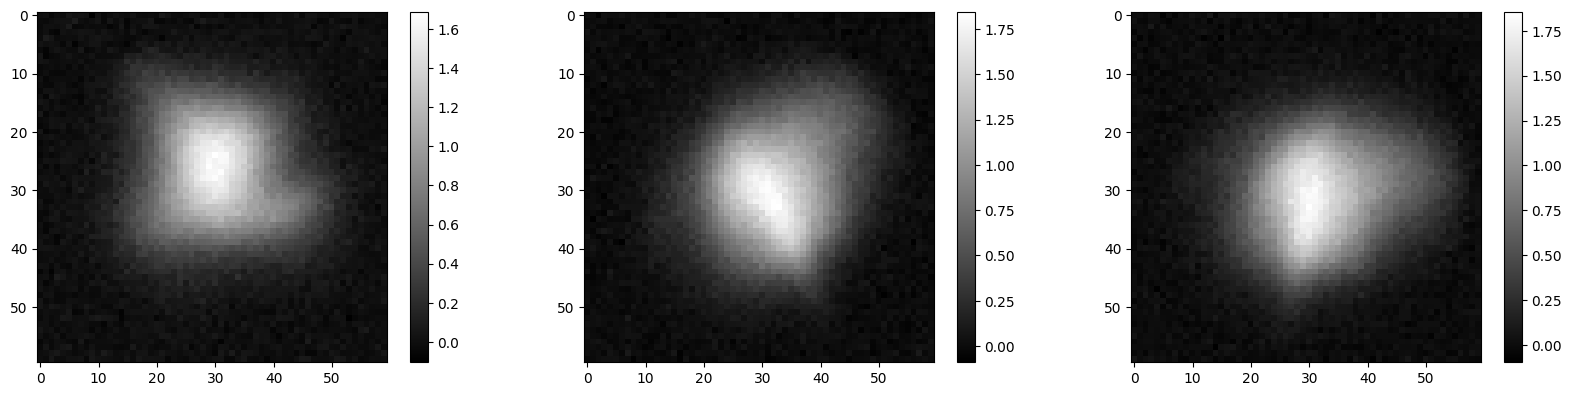

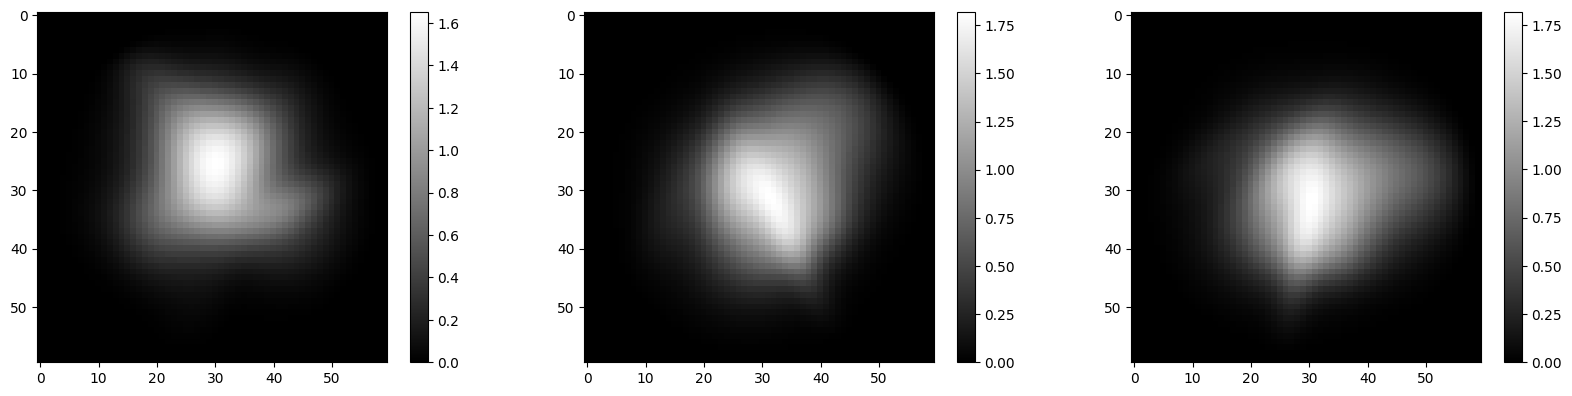

In [14]:
# Consume images from the source by providing
# a starting index and number of images.
# Here we generate the first 3 and peek at them.
src.images[:3].show()
src.projections[:3].show()

# Here we return the first n_img images as a numpy array.
dirty_ary = src.images[:n_img].asnumpy()

# And we have access to the clean images
clean_ary = src.projections[:n_img].asnumpy()

# Similary, the angles/rotations/shifts/amplitudes etc.

In [15]:
basis = FSPCABasis(src = src, components=400, batch_size=512)

2023-03-06 17:16:55,148 INFO [aspire.basis.ffb_2d] Expanding 2D image in a frequency-domain Fourier–Bessel basis using the fast method.
2023-03-06 17:16:55,371 INFO [aspire.basis.fspca] Estimating the noise of images.
2023-03-06 17:16:55,371 INFO [aspire.noise.noise] Determining Noise variance in batches of 512


100%|██████████| 1/1 [00:00<00:00,  9.28it/s]

2023-03-06 17:16:55,483 INFO [aspire.noise.noise] Noise variance = 0.0009740985562825987
2023-03-06 17:16:55,485 INFO [aspire.basis.fspca] Setting noise_var=0.0009740985697135329
2023-03-06 17:16:55,487 INFO [aspire.covariance.covar2d] CTF filters are not included in Cov2D denoising


In [16]:
basis.cov2d.basis.evaluate_t(src.images[0])

array([[ 3.3157856e+00,  4.9681821e+00,  6.0432968e+00, ...,
         1.1870376e-02, -6.4910325e-04,  3.4838822e-02]], dtype=float32)

In [1]:
import logging
import os

import numpy as np

from aspire.noise import WhiteNoiseAdder
from aspire.source.simulation import Simulation
from aspire.utils import Rotation
from aspire.basis import FSPCABasis
from aspire.volume import Volume

logger = logging.getLogger(__name__)

src2 = Simulation(  # our Volume
    L=60,  # resolution, should match Volume
    n=100,  # number of projection images
    seed=12345,  # RNG seed for reproducibility
)

basic2 = FSPCABasis(src = src2, components=400, batch_size=512)

basic2.cov2d.basis.evaluate_t(src2.images[0])


2023-03-06 17:20:01,448 INFO [aspire.source.image] Creating Simulation with 100 images.
2023-03-06 17:20:01,468 INFO [aspire.basis.ffb_2d] Expanding 2D image in a frequency-domain Fourier–Bessel basis using the fast method.
2023-03-06 17:20:01,696 INFO [aspire.basis.fspca] Estimating the noise of images.
2023-03-06 17:20:01,696 INFO [aspire.noise.noise] Determining Noise variance in batches of 512


  0%|          | 0/1 [00:00<?, ?it/s]

2023-03-06 17:20:01,703 INFO [aspire.nufft] Trying NFFT backend cufinufft
2023-03-06 17:20:01,705 INFO [aspire.nufft] NFFT backend cufinufft not usable:
	No module named 'pycuda'
2023-03-06 17:20:01,707 INFO [aspire.nufft] Trying NFFT backend finufft
2023-03-06 17:20:01,712 INFO [aspire.nufft] NFFT backend finufft usable.
2023-03-06 17:20:01,713 INFO [aspire.nufft] Trying NFFT backend pynfft
2023-03-06 17:20:01,714 INFO [aspire.nufft] NFFT backend pynfft not usable:
	No module named 'pynfft'
2023-03-06 17:20:01,716 INFO [aspire.nufft] Selected NFFT backend = finufft.


100%|██████████| 1/1 [00:00<00:00,  4.23it/s]

2023-03-06 17:20:01,937 INFO [aspire.noise.noise] Noise variance = 0.0005174962968735282
2023-03-06 17:20:01,940 INFO [aspire.basis.fspca] Setting noise_var=0.0005174963152967393
2023-03-06 17:20:01,942 INFO [aspire.covariance.covar2d] CTF filters are not included in Cov2D denoising


array([[ 4.0970569e+00,  6.1992750e+00,  7.6537838e+00, ...,
        -6.7552623e-06,  6.5397389e-06,  7.4432892e-06]], dtype=float32)